In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
# Temos dados de 2002 até 2018

df = pd.read_csv('datasets\PJME_hourly.csv')
display(df.head(), df.tail(), df.shape)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


(145366, 2)

In [3]:
df.isna().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [4]:
# Não temos dados faltando, mas temos a coluna DateTime como 'Object', vamos mudar para date time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [5]:
# Mudando para datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Chegando novamente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


##### 1. EDA

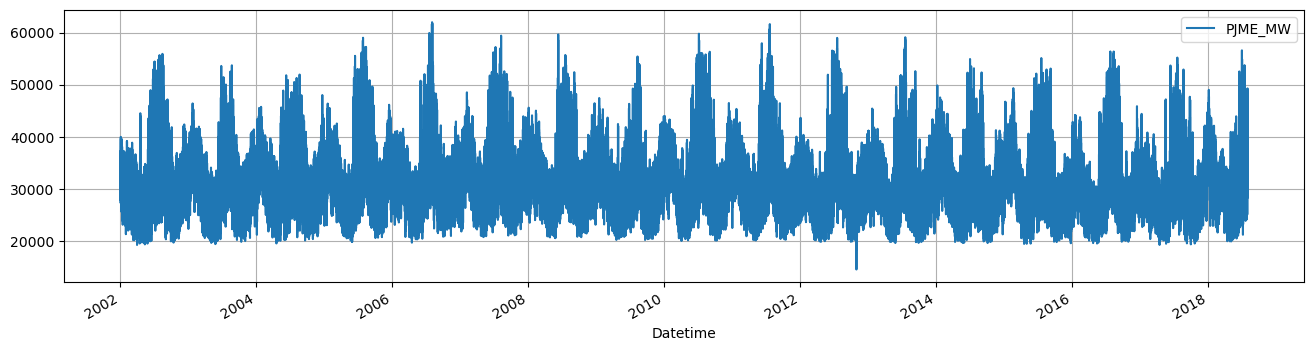

In [6]:
f, ax = plt.subplots(figsize=(16, 4))

df.plot( x = 'Datetime', y = 'PJME_MW', ax = ax)
ax.grid()
ax.legend()

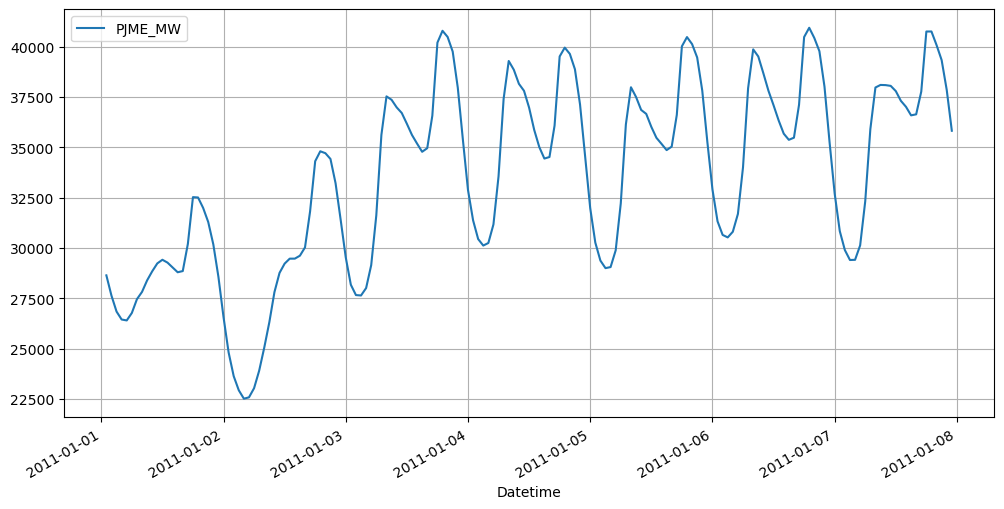

In [7]:
# Vou fazer alguns plot de semanas, para olhar o comportamento ao longo de uma semana
f, ax = plt.subplots(figsize=(12, 6))

df[(df['Datetime'] > '01-01-2011') & (df['Datetime'] < '01-08-2011')].plot(x = 'Datetime', y = 'PJME_MW', ax = ax)
ax.legend()
ax.grid()

In [8]:
# Train / Test Split
# Como é um exemplo simples, eles não usam o test/train split do scikit ou crossvalidation
# So separar os dados por data, tendo um bom senso ja é o suficiente

train = df[df['Datetime'] < '01-01-2015']
test = df[df['Datetime'] > '01-01-2015']

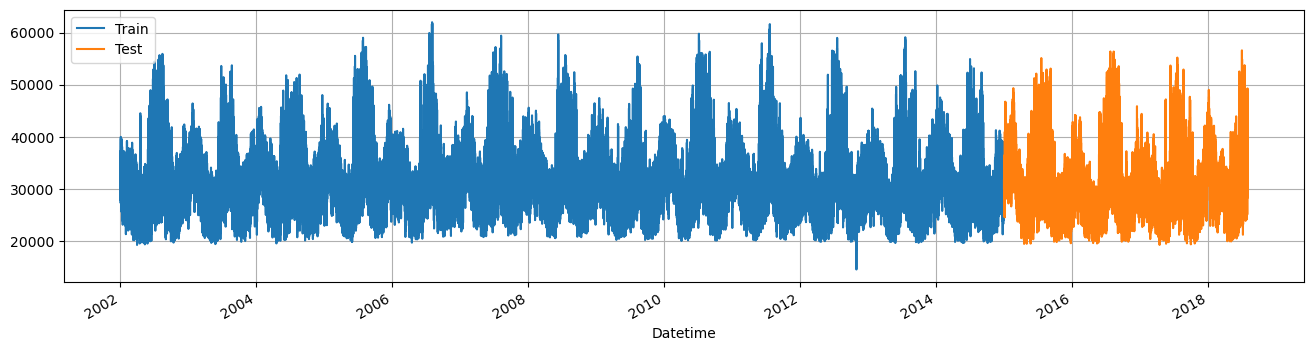

In [9]:
f, ax = plt.subplots(figsize=(16, 4))

train.plot(x = 'Datetime', y = 'PJME_MW', ax = ax)
test.plot(x = 'Datetime', y = 'PJME_MW', ax = ax)
ax.grid()
ax.legend(['Train', 'Test'])
plt.show()

In [10]:
# df['Datetime'].dt.isocalendar().week
df['Datetime'].dt.hour

0          1
1          2
2          3
3          4
4          5
          ..
145361    20
145362    21
145363    22
145364    23
145365     0
Name: Datetime, Length: 145366, dtype: int64

In [11]:
# Features
# Criar features usando a coluna datetime que temos, de forma resumida so vou sair tirando infos da coluna com formato de data
# Da para tirar valor de hora, dia da semana, mes...dentre outros

df = df.copy()
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['quarter'] = df['Datetime'].dt.quarter
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year
df['dayofyear'] = df['Datetime'].dt.dayofyear
#df['dayofmonth'] = df['Datetime'].dt.day
#df['weekofyear'] = df['Datetime'].dt.isocalendar().week

In [12]:
df.shape

(145366, 8)

In [13]:
# Fazer isso para Train / Test
# Train
train = train.copy()
train['hour'] = train['Datetime'].dt.hour
train['dayofweek'] = train['Datetime'].dt.dayofweek
train['quarter'] = train['Datetime'].dt.quarter
train['month'] = train['Datetime'].dt.month
train['year'] = train['Datetime'].dt.year
train['dayofyear'] = train['Datetime'].dt.dayofyear
#train['dayofmonth'] = train['Datetime'].dt.day

# Test
test = test.copy()
test['hour'] = test['Datetime'].dt.hour
test['dayofweek'] = test['Datetime'].dt.dayofweek
test['quarter'] = test['Datetime'].dt.quarter
test['month'] = test['Datetime'].dt.month
test['year'] = test['Datetime'].dt.year
test['dayofyear'] = test['Datetime'].dt.dayofyear
#test['dayofmonth'] = test['Datetime'].dt.day

print(train.shape, test.shape)

(113926, 8) (31439, 8)


##### 2. Machine Learning

In [14]:
# ML

y = ['PJME_MW']
X = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']

X_train = train[X]
y_train = train[y]

X_test = test[X]
y_test = test[y]


In [15]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds=50, objective='reg:linear',
                       max_depth=3, learning_rate=0.01)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[22:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.13174
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.68216
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.63917
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.69039
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.44834
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.34918
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.49583
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.95389
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.93658
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.64965
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.95971


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

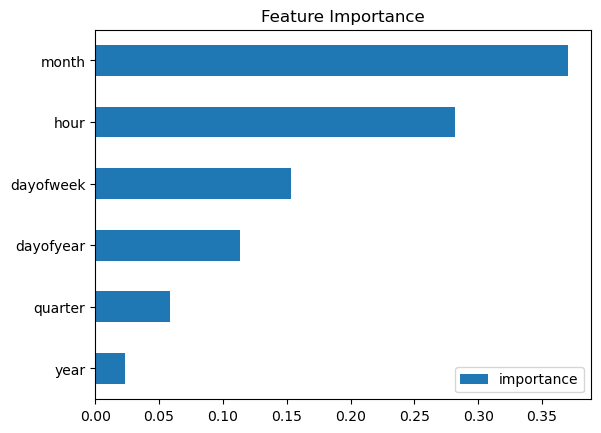

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

plt.show()

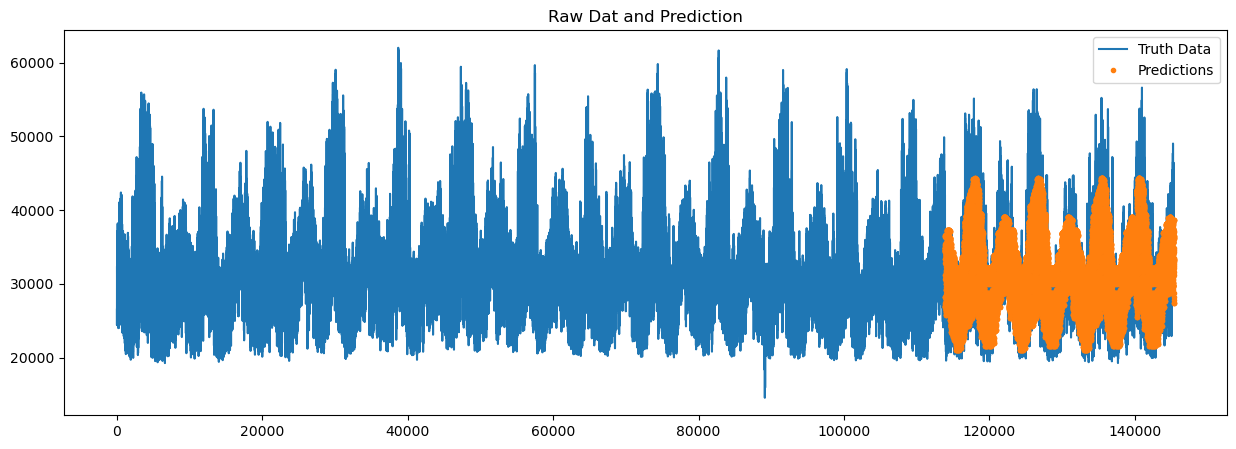

In [17]:
# Previsões
test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='.')

plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

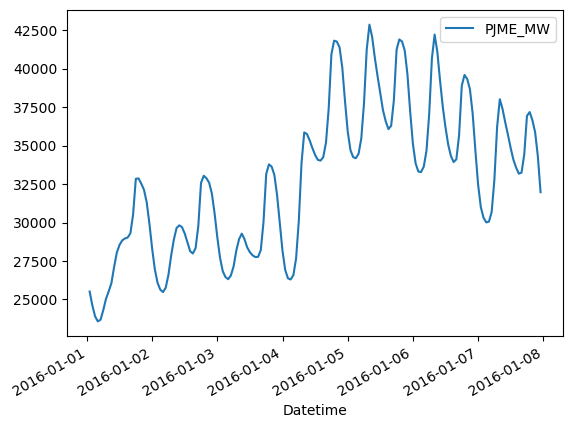

In [18]:
df[(df['Datetime'] > '01-01-2016') & (df['Datetime'] < '01-08-2016')].plot(x = 'Datetime', y = 'PJME_MW')
plt.show()

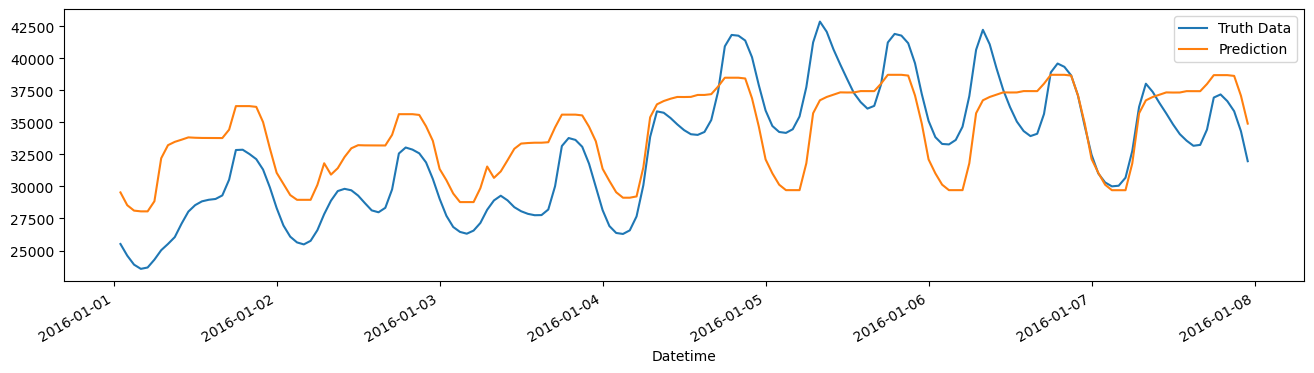

In [19]:
# Previsoes na janela com uma semana
f, ax = plt.subplots(figsize=(16, 4))

df[(df['Datetime'] > '01-01-2016') & (df['Datetime'] < '01-08-2016')].plot(x = 'Datetime', y = 'PJME_MW', ax = ax)

df[(df['Datetime'] > '01-01-2016') & (df['Datetime'] < '01-08-2016')].plot(x = 'Datetime', y = 'prediction', ax = ax)

plt.legend(['Truth Data','Prediction'])
plt.show()

In [20]:
# RMSE (Score -- Root mean squared Error)
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.78
